In [188]:
# This Jupyter notebook was created by Emily Olafson to predicit cognitive scores from structural and functional connectivity data in stroke subjects.
# Last updated: Friday Jan 14 2022
# https://github.com/emilyolafson/cognition_nemo

#import relevant libraries
import sys; sys.path
import pandas as pd
import numpy as np 
import seaborn as sns
from datetime import datetime
import pickle 
from sklearn.pipeline import Pipeline
import scipy.io as sio
from scipy.stats import spearmanr, pearsonr
from joblib import parallel_backend, Parallel, delayed
from sklearn import preprocessing, linear_model
from sklearn.metrics import explained_variance_score, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.utils.fixes import loguniform
import matplotlib as mpl


In [2]:
# Set paths
data_dir='/home/ubuntu/cognition_iowa/data/'
results_dir='/home/ubuntu/cognition_iowa/results/' 

#Load input variables (estimated SC and FC) and save all subjects to one .mat file for eFC prediction (Zijin's code)
nROIs=86
subj_id =  pd.read_csv(data_dir + 'final_subIDs.csv',header=None)[0]
sc = np.zeros([len(subj_id),3655])

for i in range(len(subj_id)):
    filename = data_dir + "sc/%s_nemo_output_chacoconn_fs86subj_nemoSC_volnorm.txt" % (subj_id[i])
    sc_tmp = pd.read_csv(filename, header=0, sep=' ').values
    np.fill_diagonal(sc_tmp, 0)
    sc[i,:] = sc_tmp[np.triu_indices(nROIs,k=1)]
    
sio.savemat(data_dir + 'allstroke_SCs.mat', {'sc':sc}) # used to predict eFC using Zijin's code.

# Load FC
fc = np.zeros([len(subj_id),3655])

for i in range(len(subj_id)):
    filename = data_dir + "fc/%s_FC.txt" % (subj_id[i])
    fc_tmp = pd.read_csv(filename, header=0, sep=' ').values
    np.fill_diagonal(sc_tmp, 0)
    fc[i,:] = fc_tmp[np.triu_indices(nROIs,k=1)]
    
    
# Load demographic variables and outcome measures (TMT and WAIS)
#read in demographic info at first time point
demo =  pd.read_csv(data_dir + 'demographic_final.csv',header=0)

#read in cognitive scores at first time point
tmt = pd.read_csv(data_dir + 'T_MT_A_TIME.csv',header=None)
wais = pd.read_csv(data_dir + 'WAIS_IV_DS_TOTAL_RAW.csv',header=None)

In [287]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    FROM: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

def prepare_data(X):
    '''Clean X-data (remove zero-value input variables)'''

    # remove inputs that are 0 for all subjects
    zeros=X==0
    zeros=np.sum(zeros,0)
    zeros=zeros==X.shape[0]
    X=X[:,~zeros]
    print("Final size of X: " + str(X.shape))
    
    return X

def np_pearson_cor(x, y):
    '''Fast array-based pearson correlation that is more efficient. 
    FROM: https://cancerdatascience.org/blog/posts/pearson-correlation/.
        x - input N x p
        y - output N x 1
        
        returns correlation p x 1 '''
    xv = x - x.mean(axis=0)
    yv = y - y.mean(axis=0)
    xvss = (xv * xv).sum(axis=0)
    yvss = (yv * yv).sum(axis=0)
    result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
    
    # bound the values to -1 to 1 in the event of precision issues
    return np.maximum(np.minimum(result, 1.0), -1.0)


def naive_pearson_cor(X, Y):
    '''Naive (scipy-based/iterative) pearson correlation. 
    FROM: https://cancerdatascience.org/blog/posts/pearson-correlation/.
        x - input N x p
        y - output N x 1
        
        returns correlation p x 1 '''
    result = np.zeros(shape=(X.shape[1], Y.shape[1]))
    for i in range(X.shape[1]):
        for j in range(Y.shape[1]):
            r, _ = pearsonr(X[:,i], Y[:,j])
            result[i,j] = r
    return result


def feature_select_PCA(x_train, x_test, a):
    """Return values for the top a PCs of x based on PCA of x.
         
         Inputs:
             x = input matrix
             y = variable/s predicted 
             a = number of PCs
         
        Returns:
            x_train_featselect = training data with selected features 
            x_test_featselect = test data matrix with selected features 
            var_expl = variance explained by top a components
            components = PCs selected"""
    
    # check that dimension of x is greater than a
    if x_train.shape[1]<a:
        raise Exception('Number of features in X is less than the number of features specified to retain (a).') 
    
    # Feature selection: use only the top n features based on top a PCs in training data 
    pca = PCA(n_components=a, copy=True, random_state=42)
    x_train_featselect = pca.fit(x_train).transform(x_train)
    x_test_featselect = pca.transform(x_test)
    components = pca.components_

    
    var_expl = pca.explained_variance_


    return x_train_featselect,x_test_featselect, var_expl, components

def feature_select_correlation(x_train, x_test, y, a):
    """Return values for the top a features of x based on abs. value Spearman correlation with y.
         Inputs:
             x = input matrix
             y = variable/s predicted 
             a = number of features to retain
        
        Returns:
            x_train_featselect = training data with selected features 
            x_test_featselect = test data matrix with selected features
            ind = indices of top a features """
    
    # check that dimension of x is greater than a
    if x_train.shape[1]<a:
        raise Exception('Number of features in X is less than the number of features specified to retain (a).') 
        
        
    # Feature selection: use only the top n features based on correlation of training features with y
    correl = abs(np_pearson_cor(x_train, y))
    ind = np.argpartition(correl, -a, 0)[-a:] # select top a features

    # return training/test data with only top features
    x_train_featselect=np.squeeze(x_train[:,ind],2)
    
    x_test_featselect=np.squeeze(x_test[:,ind],2)

    return x_train_featselect,x_test_featselect, ind


def scale_data(x_train, x_test):
    '''Scale the training data and apply transformation to the test/validation data.

        Inputs:
            x_train = training predictors
            x_test = training predictors 
        
        Returns:
            x_train_scaled
            x_test_scaled '''
    
    # Scale x_train 
    scaler = preprocessing.StandardScaler().fit(x_train)
    
    # apply transformation to train & test set.
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    return x_train_scaled, x_test_scaled


def gcv_ridge(hyperparam, x, y, k, featsel='None', a=10):
    """Perform gridsearch using k-fold cross-validation on a single hyperparameter 
    in ridge regression, and return mean R^2 across inner folds.
    
    Inputs: 
        hyperparam = list of hyperparameter values to train & test on validation est
        x = N x p input matrix
        y = 1 x p variable to predict
        k = k value in k-fold cross validation 
        featsel = type string, feature selection method, default="None"
            'None' - no feature selection; use all variables for prediction
            'correlation'- calculate the abs. val. Pearson correlation between all training variables with the varibale to predict. Use the highest 'a' variables based on their correlation for prediction
            'PCA' - perform PCA on the training variables and use the top 'a' PCs as input variables, by variance explained, for prediction
        a = number of features to select using one of the above methods, default=10 
    
    Returns:
        r2 = the mean R^2 (coefficient of determination) across inner loop folds for the given hyperparameter
    """
    
    # make sure k is reasonable 
    if x.shape[0]/k <= 2:
        raise Exception('R^2 is not well-defined with less than 2 subjects.')   
    
    # set alpha in ridge regression
    alpha = hyperparam
    
    # Initialize lists with final results
    y_pred_total = []
    y_valid_total = []
    R2 = []
    comp = []
    
    # Split data into test and train: random state fixed for reproducibility
    kf = KFold(n_splits=k,shuffle=True,random_state=43)
    
    # K-fold cross-validation 
    for train_index, valid_index in kf.split(x):
        x_train, x_valid = x[train_index], x[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        x_train, x_valid = scale_data(x_train, x_valid)
        
        if featsel=='correlation':
            x_train, x_valid, ind = feature_select_correlation(x_train, x_valid, y_train, a)
            comp.append(ind)
            
        elif featsel=='PCA':
            x_train, x_valid, var_expl, components = feature_select_PCA(x_train, x_valid, a)
            comp.append(components)

        #x_train, x_valid = feature_select_correlation(x_train, x_valid, y_train, 10)
        
        # Fit ridge regression with (x_train_scaled, y_train), and predict x_train_scaled
        regr = linear_model.Ridge(alpha=alpha, normalize=True, max_iter=1000000, random_state=42)
        y_pred = regr.fit(x_train, y_train).predict(x_valid)

        R2.append(r2_score(y_valid, y_pred))
        
        # Append y_pred and y_valid values of this k-fold step to list with total values
        y_pred_total.append(y_pred)
        y_valid_total.append(y_valid)
   
    r2=np.mean(R2)
    return r2, comp

def parallel_featsearch(alpha,feat):
    r2, comp=gcv_ridge(alpha, x, y, k, featselect, feat)
    return r2

# Inner loop - grid search
def gridsearch_cv(k, x, y, featselect):
    ''' Performs grid search using fixed predefined hyperparameter ranges and returns the best alpha and # of features for 
        a given training/validation sample. 
        
        Returns:
            bestalpha - optimal alpha based on grid search
            bestfeats - optimal number of features based on grid search
            bestr2 - mean R^2 across folds obtained for the optimal combination of hyperparameters'''
    
    print(str(k)+"-fold cross-validation results in "+str((x.shape[0]/k)*(k-1))+ " subjects in the training set, and "+ str(x.shape[0]/k) + " subjects in the validation set")

    # set hyperparameter search space
    # range of alphas
    n_alphas=20
    alpha_start=-1
    alpha_end=2
    alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    #number of features (# pricipal components or variables to retain)
    feat_start=10
    feat_end=30
    n_feats=feat_end-feat_start+1
    feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

    # initialize array to store r2
    gcv_values=np.empty(shape=(len(alphas),len(feats)),dtype='float')

    # iterate through alphas
    for alpha in alphas:
        row, = np.where(alphas==alpha)
        
        # run feature selection (# of components) in parallel
        gcv=Parallel(n_jobs=-1,verbose=0)(delayed(parallel_featsearch)(alpha, feat) for feat in feats)
        gcv=np.array(gcv)
        gcv_values[row]=gcv
            
        row=np.argmax(np.max(gcv_values, axis=1))
        col=np.argmax(np.max(gcv_values, axis=0))

    bestalpha=alphas[row]
    bestfeats=feats[col]
    bestr2=np.max(gcv_values)

    return bestalpha, bestfeats, bestr2, gcv_values, comps

In [288]:
import datetime
#set the number of folds you want in the inner and outer folds of the nested cross-validation
k = 5

#set the proportion of data you want in your training set
train_size = .8

#set x data to be the input variable you want to use
#ie fc, sc, or hc
#X=np.concatenate([sc, fc], axis=1)
X=sc
X=prepare_data(X)

#set y to be the measure you want to predict
Y = np.array(wais)

# feature selection type
featselect='PCA'

# initialize lists to store model results for each permuation
allR2=[]
meanR2=[]
features=[]
bestalphas=[]
importance=[]

#joblib-based parallelism to increase speed,

for p in range(0, 100):
    outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
    print('Permutation: ' + str(p))
    # initialize lists to store model results for eah fold
    R2=[]
    feats=[]
    best_alphas=[]
    impt=[] 

    for train, test in outer_cv.split(X):
        begin_time = datetime.datetime.now()

        # select model using training data
        bestalpha, bestfeats, bestr2, gcv_values, comps = gridsearch_cv(k, X[train], Y[train], featselect)
        
        # using optimal num. of features, select final features using entire training data.
        x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)

        # initialize Ridge regression with alpha selected from hyperparameter search
        regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

        # fit model 
        y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

        # store results for each fold k
        impt.append(regr.coef_)
        R2.append(r2_score(Y[test], y_pred))
        feats.append(ind)
        best_alphas.append(bestalpha)
        print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 

    # store results for each permutation p
    meanR2.append(np.mean(R2))
    allR2.append(R2)
    features.append(feats)
    bestalphas.append(best_alphas)
    importance.append(impt)

np.savetxt(results_dir + featselect + '_SC_allR2.txt', allR2, delimiter=',')
np.savetxt(results_dir + featselect + '_SC_meanR2.txt', meanR2, delimiter=',')

output = open(results_dir + featselect + '_SC_features.pkl', 'wb')
pickle.dump(features, output)
output.close()

output = open(results_dir + featselect + '_SC_bestalphas.pkl', 'wb')
pickle.dump(bestalphas, output)
output.close()


Final size of X: (101, 3201)
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run one loop: 0:00:19.045842
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run one loop: 0:00:16.892730
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set


KeyboardInterrupt: 

In [ ]:

#set x data to be the input variable you want to use
#ie fc, sc, or hc
#X=np.concatenate([sc, fc], axis=1)
X=fc
X=prepare_data(X)

#set y to be the measure you want to predict
Y = np.array(wais)

# feature selection type
featselect='PCA'

# initialize lists to store model results for each permuation
allR2=[]
meanR2=[]
features=[]
bestalphas=[]
importance=[]

#joblib-based parallelism to increase speed,

for p in range(0, 100):
    outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
    print('Permutation: ' + str(p))
    # initialize lists to store model results for eah fold
    R2=[]
    feats=[]
    best_alphas=[]
    impt=[] 

    for train, test in outer_cv.split(X):
        begin_time = datetime.datetime.now()

        # select model using training data
        bestalpha, bestfeats, bestr2, gcv_values, comps = gridsearch_cv(k, X[train], Y[train], featselect)
        
        # using optimal num. of features, select final features using entire training data.
        x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)

        # initialize Ridge regression with alpha selected from hyperparameter search
        regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

        # fit model 
        y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

        # store results for each fold k
        impt.append(regr.coef_)
        R2.append(r2_score(Y[test], y_pred))
        feats.append(ind)
        best_alphas.append(bestalpha)
        print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 

    # store results for each permutation p
    meanR2.append(np.mean(R2))
    allR2.append(R2)
    features.append(feats)
    bestalphas.append(best_alphas)
    importance.append(impt)

np.savetxt(results_dir + featselect + '_FC_allR2.txt', allR2, delimiter=',')
np.savetxt(results_dir + featselect + '_FC_meanR2.txt', meanR2, delimiter=',')

output = open(results_dir + featselect + '_FC_features.pkl', 'wb')
pickle.dump(features, output)
output.close()

output = open(results_dir + featselect + '_FC_bestalphas.pkl', 'wb')
pickle.dump(bestalphas, output)
output.close()

In [ ]:

#set x data to be the input variable you want to use
#ie fc, sc, or hc
X=np.concatenate([sc, fc], axis=1)
#X=fc
X=prepare_data(X)

#set y to be the measure you want to predict
Y = np.array(wais)

# feature selection type
featselect='PCA'

# initialize lists to store model results for each permuation
allR2=[]
meanR2=[]
features=[]
bestalphas=[]
importance=[]

#joblib-based parallelism to increase speed,

for p in range(0, 100):
    outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
    print('Permutation: ' + str(p))
    # initialize lists to store model results for eah fold
    R2=[]
    feats=[]
    best_alphas=[]
    impt=[] 

    for train, test in outer_cv.split(X):
        begin_time = datetime.datetime.now()

        # select model using training data
        bestalpha, bestfeats, bestr2, gcv_values, comps = gridsearch_cv(k, X[train], Y[train], featselect)
        
        # using optimal num. of features, select final features using entire training data.
        x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)

        # initialize Ridge regression with alpha selected from hyperparameter search
        regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

        # fit model 
        y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

        # store results for each fold k
        impt.append(regr.coef_)
        R2.append(r2_score(Y[test], y_pred))
        feats.append(ind)
        best_alphas.append(bestalpha)
        print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 

    # store results for each permutation p
    meanR2.append(np.mean(R2))
    allR2.append(R2)
    features.append(feats)
    bestalphas.append(best_alphas)
    importance.append(impt)

np.savetxt(results_dir + featselect + '_SCFC_allR2.txt', allR2, delimiter=',')
np.savetxt(results_dir + featselect + '_SCFC_meanR2.txt', meanR2, delimiter=',')

output = open(results_dir + featselect + '_SCFC_features.pkl', 'wb')
pickle.dump(features, output)
output.close()

output = open(results_dir + featselect + '_SCFC_bestalphas.pkl', 'wb')
pickle.dump(bestalphas, output)
output.close()

In [ ]:
#set x data to be the input variable you want to use
#ie fc, sc, or hc
#X=np.concatenate([sc, fc], axis=1)
X=sc
X=prepare_data(X)

#set y to be the measure you want to predict
Y = np.array(wais)

# feature selection type
featselect='correlation'

# initialize lists to store model results for each permuation
allR2=[]
meanR2=[]
features=[]
bestalphas=[]
importance=[]

#joblib-based parallelism to increase speed,

for p in range(0, 100):
    outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
    print('Permutation: ' + str(p))
    # initialize lists to store model results for eah fold
    R2=[]
    feats=[]
    best_alphas=[]
    impt=[] 

    for train, test in outer_cv.split(X):
        begin_time = datetime.datetime.now()

        # select model using training data
        bestalpha, bestfeats, bestr2, gcv_values, comps = gridsearch_cv(k, X[train], Y[train], featselect)
        
        # using optimal num. of features, select final features using entire training data.
        x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)

        # initialize Ridge regression with alpha selected from hyperparameter search
        regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

        # fit model 
        y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

        # store results for each fold k
        impt.append(regr.coef_)
        R2.append(r2_score(Y[test], y_pred))
        feats.append(ind)
        best_alphas.append(bestalpha)
        print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 

    # store results for each permutation p
    meanR2.append(np.mean(R2))
    allR2.append(R2)
    features.append(feats)
    bestalphas.append(best_alphas)
    importance.append(impt)

np.savetxt(results_dir + featselect + '_SC_allR2.txt', allR2, delimiter=',')
np.savetxt(results_dir + featselect + '_SC_meanR2.txt', meanR2, delimiter=',')

output = open(results_dir + featselect + '_SC_features.pkl', 'wb')
pickle.dump(features, output)
output.close()

output = open(results_dir + featselect + '_SC_bestalphas.pkl', 'wb')
pickle.dump(bestalphas, output)
output.close()


In [ ]:
#MODEL OPTIMIZATION

#set the number of folds you want in the inner and outer folds of the nested cross-validation
k = 5

#set the proportion of data you want in your training set
train_size = .8

#set x data to be the input variable you want to use
#ie fc, sc, or hc
#X=np.concatenate([sc, fc], axis=1)
X=fc
X=prepare_data(X)

#set y to be the measure you want to predict
Y = np.array(wais)

# set aside data for hold-out final testing: 
x, x_test, y, y_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=42)
# feature selection type
featselect='PCA'
bestalpha, bestfeats, bestr2, gcv_values, comps = gridsearch_cv(k, x, y, featselect)


In [285]:
42/60/60*5*100-18/60/60*5*100

3.333333333333333

In [101]:
row=np.argmax(np.max(gcv_values, axis=1))
col=np.argmax(np.max(gcv_values, axis=0))
k = 5
bestalpha=alphas[row]
bestfeats=feats[col]

print('Best combination: \n alpha = ', str(alphas[row]), '\n Features = ', str(feats[col]), '\n R^2 = ', str(np.round(np.max(gcv_values), 3)))

r2, comps=gcv_ridge(bestalpha, x, y, k, featselect, bestfeats)


Best combination: 
 alpha =  0.8858667904100825 
 Features =  15 
 R^2 =  0.134


[[24.  5. 13. 13. 17.]
 [ 5. 24.  5.  4.  6.]
 [13.  5. 24. 16. 17.]
 [13.  4. 16. 24. 17.]
 [17.  6. 17. 17. 24.]]


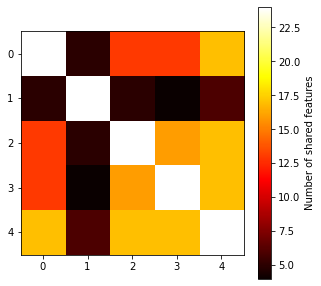

In [49]:
#Consistency of correlation feature selection
k=5
intersect=np.empty(shape=(k, k), dtype='float')

for i in range(0,k): # compare each fold to each other fold
    for j in range(0,k):
        intersect[i,j]=np.shape(np.intersect1d(comps[i], comps[j]))[0]

print(intersect)
plt.figure(figsize=(5,5))

plt.imshow(intersect, cmap='hot', interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label('Number of shared features')
plt.title('Similarity of features between folds', fontsize=20)

plt.scatter(row,col,color='k')
plt.savefig(results_dir+string+ '.png')
plt.show()

<ipython-input-62-33ad16bafe0c>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


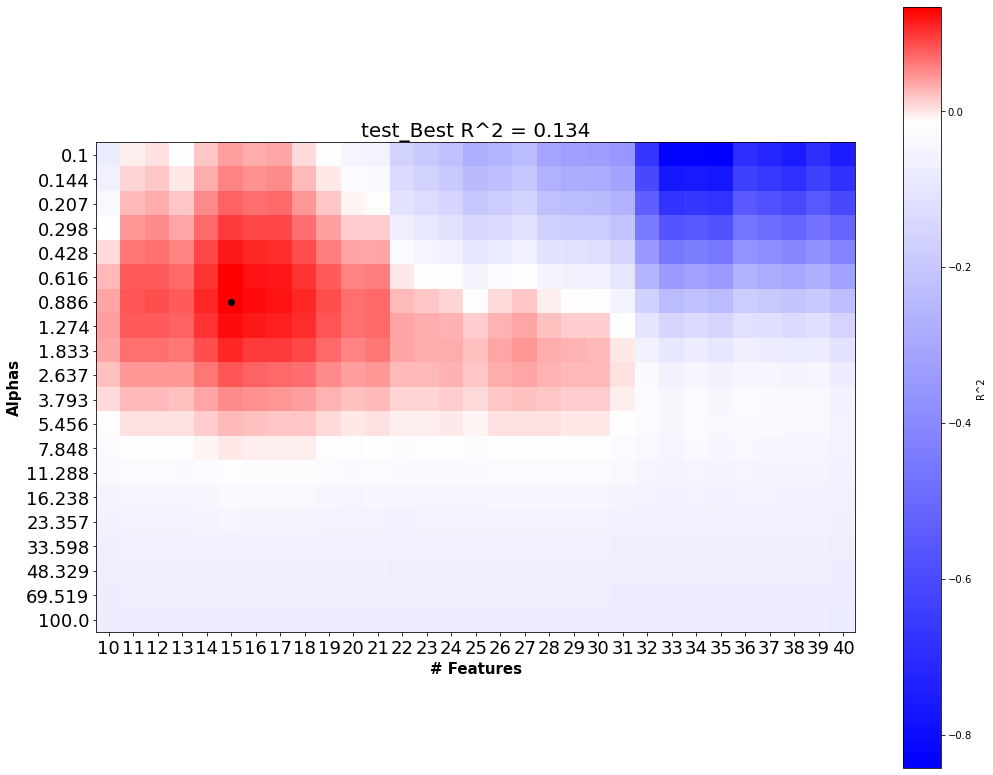

In [274]:
plot_figure(gcv_values,'test')

In [62]:
def plot_figure(gcv_values, string):
    '''Plots the R^2 value obtained across all grid-search pairs (# features and regularization values.)'''
    
    plt.figure(figsize=(17,14))
    shifted_cmap = shiftedColorMap(plt.get_cmap('bwr'), midpoint=0.85, name='shifted')

    plt.imshow(gcv_values, cmap=shifted_cmap, interpolation='nearest')

    plt.xlabel('# Features', fontsize=15, fontweight='bold')
    plt.ylabel('Alphas', fontsize=15, fontweight='bold')

    row=np.argmax(np.max(gcv_values, axis=0))
    col=np.argmax(np.max(gcv_values, axis=1))

    ax = plt.axes()

    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(1))

    xticks= np.linspace(feat_start, feat_end,n_feats, dtype=int)
    yticks= np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    plt.xticks(np.arange(len(feats)), fontsize=18)
    plt.yticks(np.arange(len(alphas)), fontsize=18)

    ax.set_xticklabels(xticks)
    ax.set_yticklabels(np.round(yticks,3))

    #ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{xticks: .2f}'))
    cbar = plt.colorbar()
    cbar.set_label('R^2')
    plt.title(string + '_Best R^2 = ' + str(np.round(np.max(gcv_values), 3)), fontsize=20)

    plt.scatter(row,col,color='k')
    plt.savefig(results_dir+string+ '.png')
    plt.show()



15


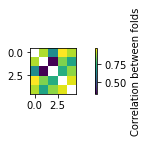

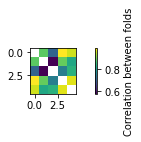

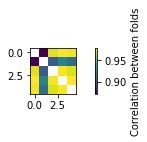

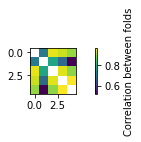

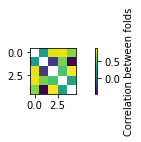

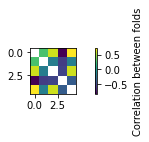

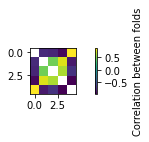

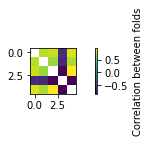

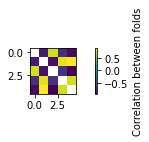

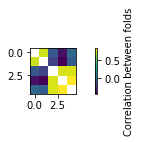

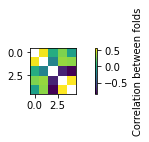

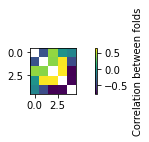

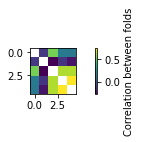

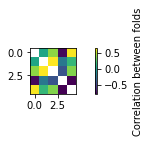

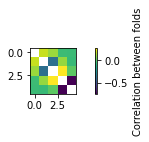

<BarContainer object of 15 artists>

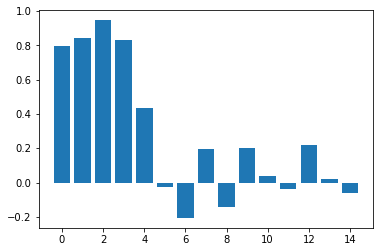

In [96]:
#Consistency of PCA feature selection

print(bestfeats)

correl=np.empty(shape=(k, k), dtype='float')
correlationp=[]
for p in range(0, bestfeats):
    for i in range(0,k): # compare each fold to each other fold
        for j in range(0,k):
            if i==j:
                correl[i,j]=np.nan
            else:
                #correlation between fold i and j for feature # p
                correl[i,j]=np.corrcoef(comps[i][p], comps[j][p])[1,0]
                #intersect[i, j]=np.intersect1d(comps[i], comps[j])
    plt.figure(figsize=(15,15))

    plt.subplot(bestfeats,2, p+1)
    plt.imshow(correl)
    cbar = plt.colorbar()
    cbar.set_label('Correlation between folds')
    plt.show()

    correlationp.append(np.nanmean(np.nanmean(correl)))
            


plt.bar(range(0, bestfeats), correlationp)
